# Menu <a class="anchor" id="menu"></a>
   
* [1. Préparation du jeu de données](#init)
    * [1.1 Séparation du jeu de données en `train`, `valid` et `test` sets](#NLP_split)
    * [1.2 Création du Corpus Bag-Of-Words](#NLP_corpus_bow)
    * [1.3 Création du Corpus TF-IDF](#NLP_corpus_tfidf)
* [2. Recherche du `modèle` de classification le plus adapté](#CLF)
    * [2.1 DummyClassifier](#CLF_dummy)
    * [2.2 LogisticRegression](#CLF_logreg)
* [3. Recherche du `pré-traitement` le plus adapté](#PREPROCESS)
    * [3.1 RAW / Aucun traitement](#PREPROCESS_raw)
    * [3.2 Preprocessing 01 / Twitter-Preprocessor](#PREPROCESS_01)
    * [3.3 Preprocessing 02 / SpaCy Tokenization](#PREPROCESS_02)
    * [3.4 Preprocessing 03 / SpaCy Filtering](#PREPROCESS_03)
    * [3.5 Preprocessing 04 / SpaCy Lemmatization](#PREPROCESS_04)
    * [3.6 Comparaison des scores](#PREPROCESS_scores)

In [1]:
import time
import pathlib
import pandas as pd
import numpy as np

import joblib

random_seed = 0
np.random.seed(random_seed)

---
---
# 1. Préparation du jeu de données <a class="anchor" id="init"></a> [⇪](#menu)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import LabelEncoder

def preprocess_data(data_nlp, col_name='lemmas', test_size=0.2):
    
    # Target encoding (NOT required anymore with the prepared dataset)
    # label_encoder = LabelEncoder()
    # targets = label_encoder.fit_transform(data_nlp.target)

    # Split the dataset
    df_train, df_test, y_train, y_test = train_test_split(data_nlp[col_name], data_nlp.target, test_size=test_size, random_state=random_seed)
    print(f"DataFrames shapes >> df_train: {df_train.shape}, df_test:{df_test.shape}, y_train:{y_train.shape}, y_test:{y_test.shape}")
    print(f"Preview:\n{df_train[:2]}")

    # Prepare corpus for train & test sets
    #corpus_train = [" ".join(x) for x in df_train]
    #corpus_test = [" ".join(x) for x in df_test]
    #print(f"Corpus preview: {corpus_train[:2]}")

    # Prepare TF-IDF 
    tfidf_vectorizer_train = TfidfVectorizer(use_idf=True, min_df=5, max_df=0.5) #, max_features=2000)
    X_train = tfidf_vectorizer_train.fit_transform(df_train)
    X_test = tfidf_vectorizer_train.transform(df_test)
    
    print(f"TF-IDF features: {tfidf_vectorizer_train.get_feature_names_out()}")
    print(f"Sets shapes >> X_train: {X_train.shape}, X_test: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test, tfidf_vectorizer_train

### Chargeons le jeu de données avec toutes les étapes de pré-processing faites dans 01_EDA.ipynb

In [3]:
data_full = pd.read_csv(pathlib.Path(pathlib.Path().absolute(), 'data', 'data_nlp_500000.csv'))
display(data_full.head(), data_full.shape)

,target,text,text_clean,tokens,tokens_filtered_advanced,tokens_filtered_simple,lemmas_filtered_advanced,lemmas_filtered_simple
0,1,"OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING...","OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING...","omg yes yes yes , degrassi 's on and i m watch...",omg yes yes yes watching finallllly <3,omg yes yes yes m watching finallllly <3,omg yes yes yes watch finallllly <3,omg yes yes yes m watch finallllly <3
1,1,@martyndarkly And it's an excuse to get a Wii.,And it's an excuse to get a Wii.,and it 's an excuse to get a wii .,excuse wii,excuse wii,excuse wii,excuse wii
2,0,@joerico I don't have a pool anymore The su...,I don't have a pool anymore The summer will be...,i do n't have a pool anymore the summer will b...,pool anymore summer long,pool anymore summer long,pool anymore summer long,pool anymore summer long
3,1,@araceli02 you know you were doing well with t...,you know you were doing well with trying to cl...,you know you were doing well with trying to cl...,know trying classify medical condition,know trying classify medical condition,know try classify medical condition,know try classify medical condition
4,1,btw i cant wait to get my tattoos,btw i cant wait to get my tattoos,btw i ca nt wait to get my tattoos,btw nt wait tattoos,btw nt wait tattoos,btw not wait tattoo,btw not wait tattoo


(464705, 8)

### Préparons les jeux de données des differents pré-processing

In [4]:
data_raw = data_full[['target','text']]
print("\n", " DATA RAW ".center(55, '-'))
display(data_raw.head(2), data_raw.shape)

data_preprocess_01 = data_full[['target','text_clean']]
print("\n", " DATA TWITTER-PREPROCESS ".center(55, '-'))
display(data_preprocess_01.head(2), data_preprocess_01.shape)

data_preprocess_02 = data_full[['target','tokens']]
print("\n", " DATA SpaCy TOKENS ".center(55, '-'))
display(data_preprocess_02.head(2), data_preprocess_02.shape)

data_preprocess_03 = data_full[['target','tokens_filtered_advanced']]
print("\n", " DATA SpaCy FILTERED TOKENS ".center(55, '-'))
display(data_preprocess_03.head(2), data_preprocess_03.shape)

data_preprocess_03_simple = data_full[['target','tokens_filtered_simple']]
print("\n", " DATA SpaCy FILTERED TOKENS (avec filtrage simple) ".center(55, '-'))
display(data_preprocess_03.head(2), data_preprocess_03.shape)

data_preprocess_04 = data_full[['target','lemmas_filtered_advanced']]
print("\n", " DATA SpaCy LEMMAS ".center(55, '-'))
display(data_preprocess_04.head(2), data_preprocess_04.shape)

data_preprocess_04_simple = data_full[['target','lemmas_filtered_simple']]
print("\n", " DATA SpaCy LEMMAS (avec filtrage simple) ".center(55, '-'))
display(data_preprocess_04.head(2), data_preprocess_04.shape)


 ----------------------- DATA RAW ----------------------


,target,text
0,1,"OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING..."
1,1,@martyndarkly And it's an excuse to get a Wii.


(464705, 2)


 --------------- DATA TWITTER-PREPROCESS ---------------


,target,text_clean
0,1,"OMG YES YES YES, DEGRASSI'S ON AND IM WATCHING..."
1,1,And it's an excuse to get a Wii.


(464705, 2)


 ------------------ DATA SpaCy TOKENS ------------------


,target,tokens
0,1,"omg yes yes yes , degrassi 's on and i m watch..."
1,1,and it 's an excuse to get a wii .


(464705, 2)


 -------------- DATA SpaCy FILTERED TOKENS -------------


,target,tokens_filtered_advanced
0,1,omg yes yes yes watching finallllly <3
1,1,excuse wii


(464705, 2)


 -- DATA SpaCy FILTERED TOKENS (avec filtrage simple) --


,target,tokens_filtered_advanced
0,1,omg yes yes yes watching finallllly <3
1,1,excuse wii


(464705, 2)


 ------------------ DATA SpaCy LEMMAS ------------------


,target,lemmas_filtered_advanced
0,1,omg yes yes yes watch finallllly <3
1,1,excuse wii


(464705, 2)


 ------- DATA SpaCy LEMMAS (avec filtrage simple) ------


,target,lemmas_filtered_advanced
0,1,omg yes yes yes watch finallllly <3
1,1,excuse wii


(464705, 2)

---
---
# 2. Recherche d'un modèle de classification <a class="anchor" id="CLF"></a> [⇪](#menu)

### Séparons le jeu de données en `Train` et `Test` sets
> Pour cette première étape nous allons utiliser le jeu de données `data_raw`

In [5]:
X_train, X_test, y_train, y_test, tfidf_vectorizer_train = preprocess_data(data_raw, 'text', test_size=0.2)

DataFrames shapes >> df_train: (371764,), df_test:(92941,), y_train:(371764,), y_test:(92941,)
Preview:
378347    @gotcoff33  i just might be making another one...
263306      ... not a man in 10,000 a poor girl can trust. 
Name: text, dtype: object
TF-IDF features: ['00' '000' '000th' ... 'øª' 'ø³ù' 'ø¹ù']
Sets shapes >> X_train: (371764, 27158), X_test: (92941, 27158)


### Chargeons les fonctions de classification écrites sur les projets précédents

In [6]:
from classification_utils import fit_model, get_scores, init_scores

init_scores("data/scores_classique.csv")

### Définissons une méthode de `cross-validation`

In [7]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

## 2.1 Établissons une base-line avec un algorithm naïf *(Dummy Classifier)* <a class="anchor" id="CLF_dummy"></a> [⇪](#menu)

In [8]:
from sklearn.dummy import DummyClassifier

In [9]:
model_name = "DummyClassifier (RAW + TF-IDF)"

In [10]:
grd_dummy = fit_model( 
    DummyClassifier(),
    param_grid={ 'random_state':[random_seed], 'strategy':['stratified'] }, 
    cv = skfold,
    verbose=2,
    X_ref = X_train,
    y_ref = y_train,
)

/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/venvP7/lib/python3.8/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5017
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5000
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5010
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.4974
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5000

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5000 (std:0.0015)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- DummyClassifier (RAW + TF-IDF) -----------------------------------------------------------------

             ROC_AUC : 0.5012
                  F1 : 0.4969
            ACCURACY : 0.5013
           PRECISION : 0.4960
              RECALL : 0.4978
   AVERAGE_PRECISION : 0.4954

       TRAINING-TIME : 1.6989
      INFERENCE-TIME : 0.0126

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.51      0.50      0.51     46958
Prediction = 1       0.50      0.50      0.50     45983

      accuracy                           0.50     92941
     macro avg       0

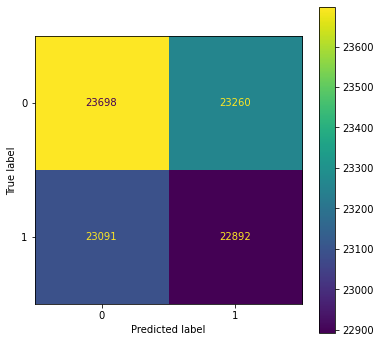

--- ROC AUC ---------------------------------------------------------------------------------------- 



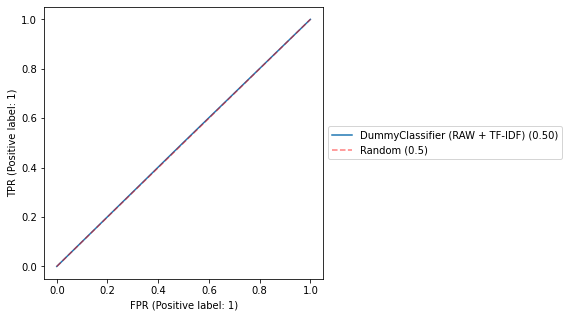

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



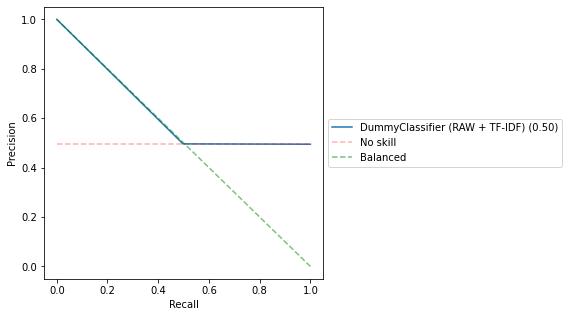

In [11]:
get_scores(model_name, **grd_dummy, register=True, X_ref=X_test, y_ref=y_test)

In [12]:
del grd_dummy

## 2.2 Essayons un algorithme linéaire - Logistic Regression <a class="anchor" id="CLF_logreg"></a> [⇪](#menu)

In [13]:
from sklearn.linear_model import LogisticRegression

In [14]:
from scipy.stats import uniform, loguniform

In [15]:
max_lr_iter = 3000
param_grid = [
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['saga'],
        'penalty' : ['elasticnet'], # none
        'C' : loguniform(1e-5, 1e2),
        'l1_ratio' : uniform(0,1)
    },
]

In [16]:
model_name = "LogisticRegression (RAW + TF-IDF)"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7975
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7968
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7976
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7959
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7947

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7965 (std:0.0011)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (RAW + TF-IDF) --------------------------------------------------------------

             ROC_AUC : 0.8703
                  F1 : 0.7903
            ACCURACY : 0.7909
           PRECISION : 0.7841
              RECALL : 0.7966
   AVERAGE_PRECISION : 0.8683

       TRAINING-TIME : 207.4236
      INFERENCE-TIME : 0.0313

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.80      0.79      0.79     46958
Prediction = 1       0.78      0.80      0.79     45983

      accuracy                           0.79     92941
     macro avg      

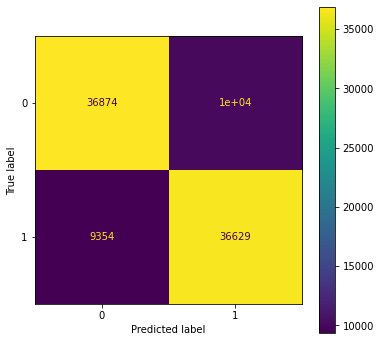

--- ROC AUC ---------------------------------------------------------------------------------------- 



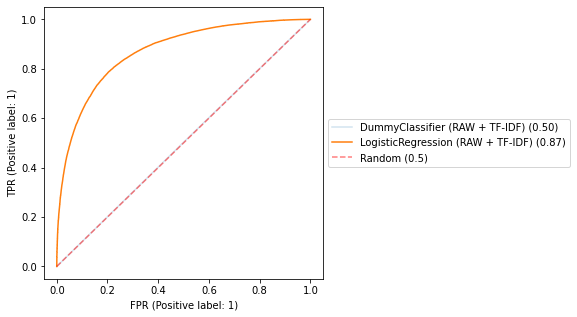

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



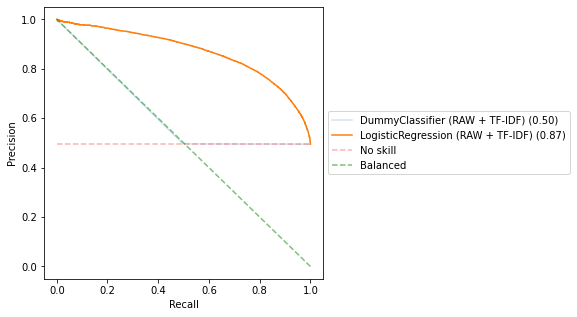

In [17]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
---
# 3. Recherche du `pré-traitement` le plus adapté <a class="anchor" id="PREPROCESS"></a> [⇪](#menu)

---
## 3.1 RAW / Aucun pré-processing <a class="anchor" id="PREPROCESS_raw"></a> [⇪](#menu)

### Nous avons déjà calculé ce modèle, donc nous n'allons pas le refaire, mais nous pouvons afficher les résultats une seconde fois

/home/valkea/Dev/OpenClassrooms/Projets_AI/P7/venvP7/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return asarray(a).ndim


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (RAW + TF-IDF) --------------------------------------------------------------

             ROC_AUC : 0.8703
                  F1 : 0.7903
            ACCURACY : 0.7909
           PRECISION : 0.7841
              RECALL : 0.7966
   AVERAGE_PRECISION : 0.8683

       TRAINING-TIME : 207.4236
      INFERENCE-TIME : 0.0091

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.80      0.79      0.79     46958
Prediction = 1       0.78      0.80      0.79     45983

      accuracy                           0.79     92941
     macro avg      

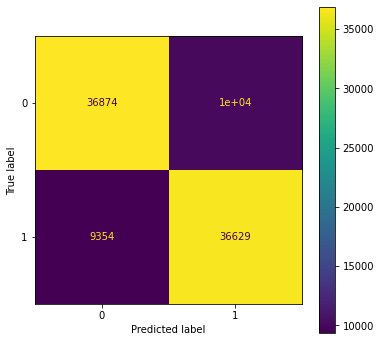

--- ROC AUC ---------------------------------------------------------------------------------------- 



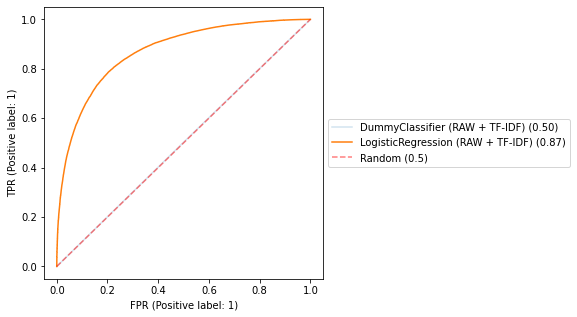

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



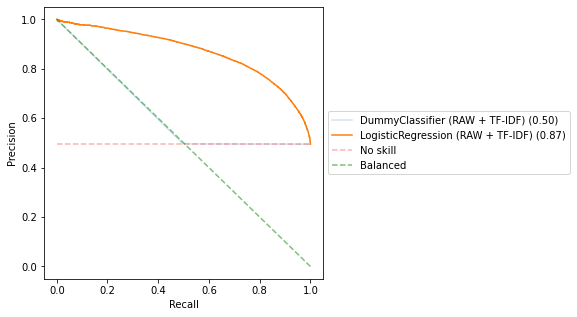

In [18]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
## 3.2 Preprocessing 01 / Twitter-Preprocessor <a class="anchor" id="PREPROCESS_01"></a> [⇪](#menu)
> Pour ce jeu de données on à utiliser la librairie python [tweet-preprocessor](https://pypi.org/project/tweet-preprocessor/) afin de supprimer les MENTIONS, les URL et mots réservés *(RT, FAV, ...)*

### Séparons le jeu de données en `Train` et `Test` sets

In [19]:
X_train, X_test, y_train, y_test, tfidf_vectorizer_train = preprocess_data(data_preprocess_01, 'text_clean', test_size=0.2)

DataFrames shapes >> df_train: (371764,), df_test:(92941,), y_train:(371764,), y_test:(92941,)
Preview:
378347       i just might be making another one tonight!
263306    ... not a man in 10,000 a poor girl can trust.
Name: text_clean, dtype: object
TF-IDF features: ['00' '000' '000th' ... 'øª' 'ø³ù' 'ø¹ù']
Sets shapes >> X_train: (371764, 23678), X_test: (92941, 23678)


### Appliquons la Logistic Regression avec ce jeu de données

In [20]:
model_name = "LogisticRegression (PREPROCESS01 + TF-IDF)"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7983
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7976
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7985
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7967
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7952

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7973 (std:0.0012)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (PREPROCESS01 + TF-IDF) -----------------------------------------------------

             ROC_AUC : 0.8703
                  F1 : 0.7905
            ACCURACY : 0.7910
           PRECISION : 0.7842
              RECALL : 0.7969
   AVERAGE_PRECISION : 0.8685

       TRAINING-TIME : 209.4251
      INFERENCE-TIME : 0.0256

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.80      0.79      0.79     46958
Prediction = 1       0.78      0.80      0.79     45983

      accuracy                           0.79     92941
     macro avg      

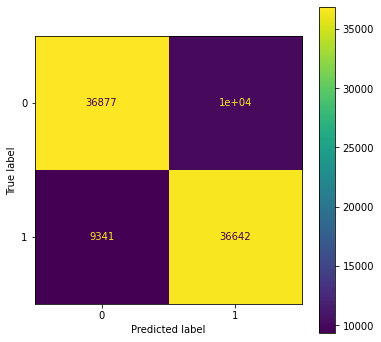

--- ROC AUC ---------------------------------------------------------------------------------------- 



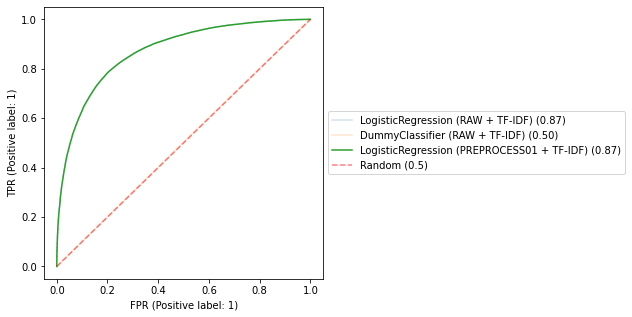

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



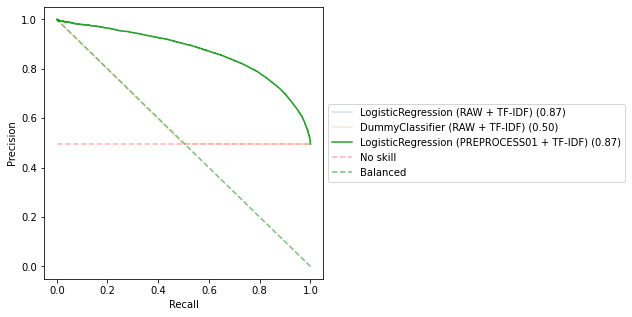

In [21]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
## 3.3 Preprocessing 02 / SpaCy Tokenization <a class="anchor" id="PREPROCESS_02"></a> [⇪](#menu)
> Pour ce jeu de données on à utilisé le jeu de données précèdent (data_preprocess_01) que l'on a Tokenisé en utilisant SpaCy. On en a profité pour supprimer les espaces en début et fin de ligne et pour retirer les majuscules *(était-ce une bonne idée ?)*

### Séparons le jeu de données en `Train` et `Test` sets

In [22]:
X_train, X_test, y_train, y_test, tfidf_vectorizer_train = preprocess_data(data_preprocess_02, 'tokens', test_size=0.2)

DataFrames shapes >> df_train: (371764,), df_test:(92941,), y_train:(371764,), y_test:(92941,)
Preview:
378347       i just might be making another one tonight !
263306    ... not a man in 10,000 a poor girl can trust .
Name: tokens, dtype: object
TF-IDF features: ['00' '000' '000th' ... 'øª' 'ø³ù' 'ø¹ù']
Sets shapes >> X_train: (371764, 23629), X_test: (92941, 23629)


### Appliquons la Logistic Regression avec ce jeu de données

In [23]:
model_name = "LogisticRegression (PREPROCESS02 + TF-IDF)"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7991
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7984
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7993
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7979
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7962

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7982 (std:0.0012)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (PREPROCESS02 + TF-IDF) -----------------------------------------------------

             ROC_AUC : 0.8699
                  F1 : 0.7902
            ACCURACY : 0.7906
           PRECISION : 0.7834
              RECALL : 0.7971
   AVERAGE_PRECISION : 0.8674

       TRAINING-TIME : 211.5099
      INFERENCE-TIME : 0.0325

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.80      0.78      0.79     46958
Prediction = 1       0.78      0.80      0.79     45983

      accuracy                           0.79     92941
     macro avg      

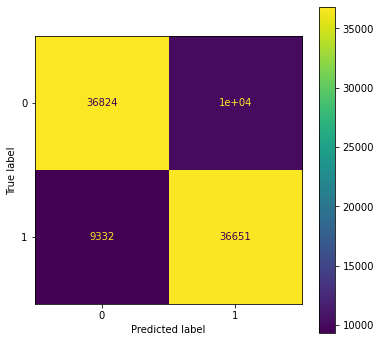

--- ROC AUC ---------------------------------------------------------------------------------------- 



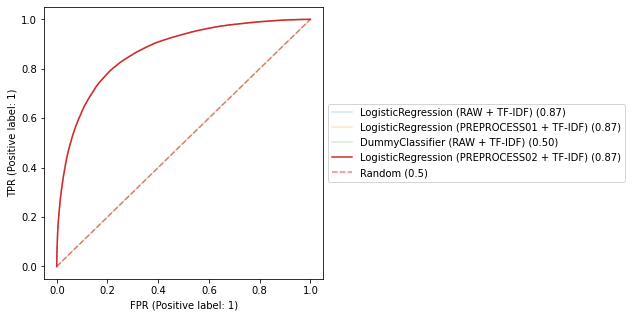

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



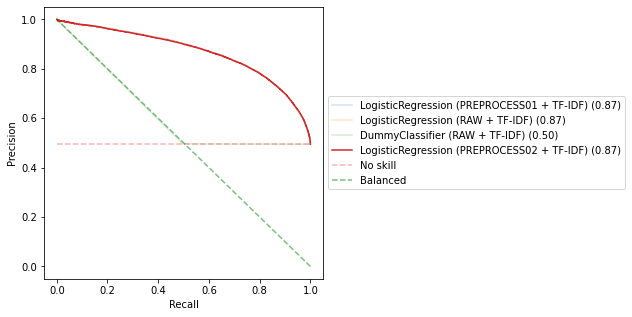

In [24]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
## 3.4 Preprocessing 03 / SpaCy Filtering <a class="anchor" id="PREPROCESS_03"></a> [⇪](#menu)
> Pour ce jeu de données on à utilisé le jeu de données précèdent (data_preprocess_02) que l'on a Filtré en utilisant les pos tags des tokens SpaCy collecté précèdement.

### Séparons le jeu de données en `Train` et `Test` sets

In [25]:
X_train, X_test, y_train, y_test, tfidf_vectorizer_train = preprocess_data(data_preprocess_03, 'tokens_filtered_advanced', test_size=0.2)

DataFrames shapes >> df_train: (371764,), df_test:(92941,), y_train:(371764,), y_test:(92941,)
Preview:
378347                making tonight
263306    man 10,000 poor girl trust
Name: tokens_filtered_advanced, dtype: object
TF-IDF features: ['00' '000' '000th' ... 'ð¾' 'ð¾ð' 'ð¾ñ']
Sets shapes >> X_train: (371764, 19838), X_test: (92941, 19838)


### Appliquons la Logistic Regression avec ce jeu de données

In [26]:
model_name = "LogisticRegression (PREPROCESS03 + TF-IDF)"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7718
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7728
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7728
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7732
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7717

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7725 (std:0.0008)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (PREPROCESS03 + TF-IDF) -----------------------------------------------------

             ROC_AUC : 0.8396
                  F1 : 0.7644
            ACCURACY : 0.7616
           PRECISION : 0.7480
              RECALL : 0.7816
   AVERAGE_PRECISION : 0.8300

       TRAINING-TIME : 111.7124
      INFERENCE-TIME : 0.0306

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.78      0.74      0.76     46958
Prediction = 1       0.75      0.78      0.76     45983

      accuracy                           0.76     92941
     macro avg      

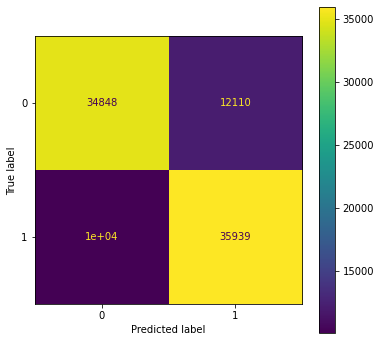

--- ROC AUC ---------------------------------------------------------------------------------------- 



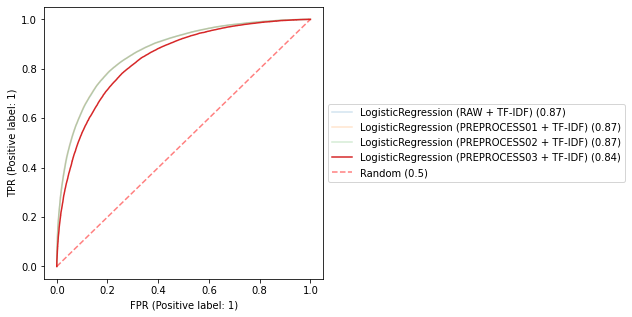

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



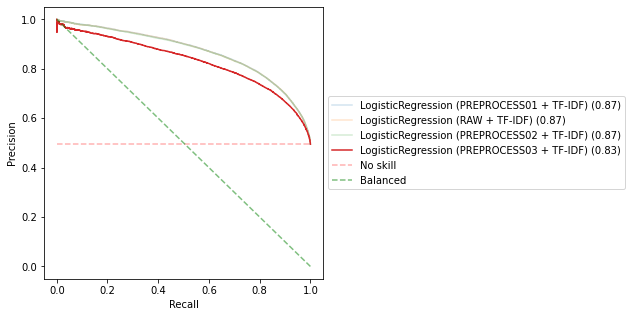

In [27]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

## Testons la même chose avec le jeu de données qui a été filtré avec des règles plus simples

### Séparons le jeu de données en `Train` et `Test` sets

In [29]:
X_train, X_test, y_train, y_test, tfidf_vectorizer_train = preprocess_data(data_preprocess_03_simple, 'tokens_filtered_simple', test_size=0.2)

DataFrames shapes >> df_train: (371764,), df_test:(92941,), y_train:(371764,), y_test:(92941,)
Preview:
378347                making tonight
263306    man 10,000 poor girl trust
Name: tokens_filtered_simple, dtype: object
TF-IDF features: ['00' '000' '000th' ... 'ð¾' 'ð¾ð' 'ð¾ñ']
Sets shapes >> X_train: (371764, 19905), X_test: (92941, 19905)


### Appliquons la Logistic Regression avec ce jeu de données

In [30]:
model_name = "LogisticRegression (PREPROCESS03_simple + TF-IDF)"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7731
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7741
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7743
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7746
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7731

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7738 (std:0.0008)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (PREPROCESS03_simple + TF-IDF) ----------------------------------------------

             ROC_AUC : 0.8407
                  F1 : 0.7654
            ACCURACY : 0.7628
           PRECISION : 0.7494
              RECALL : 0.7821
   AVERAGE_PRECISION : 0.8312

       TRAINING-TIME : 109.7791
      INFERENCE-TIME : 0.0154

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.78      0.74      0.76     46958
Prediction = 1       0.75      0.78      0.77     45983

      accuracy                           0.76     92941
     macro avg      

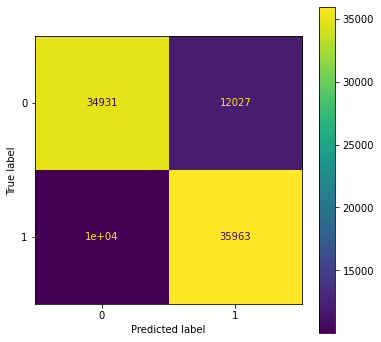

--- ROC AUC ---------------------------------------------------------------------------------------- 



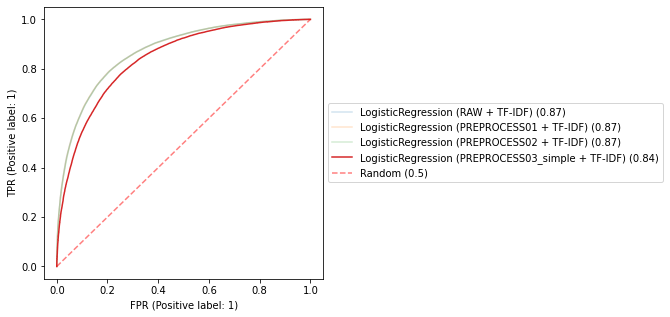

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



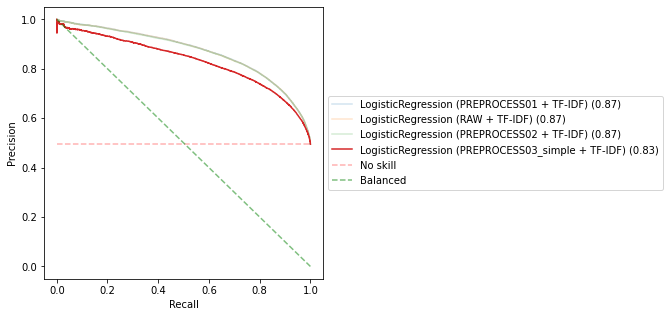

In [31]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
## 3.5 Preprocessing 04 / SpaCy Lemmatization <a class="anchor" id="PREPROCESS_04"></a> [⇪](#menu)
> Pour ce jeu de données on à utilisé le jeu de données précèdent (data_preprocess_03) que l'on a Lemmatisé en utilisant SpaCy.

### Séparons le jeu de données en `Train` et `Test` sets

In [32]:
X_train, X_test, y_train, y_test, tfidf_vectorizer_train = preprocess_data(data_preprocess_04, 'lemmas_filtered_advanced', test_size=0.2)

DataFrames shapes >> df_train: (371764,), df_test:(92941,), y_train:(371764,), y_test:(92941,)
Preview:
378347                  make tonight
263306    man 10,000 poor girl trust
Name: lemmas_filtered_advanced, dtype: object
TF-IDF features: ['00' '000' '000th' ... 'ð¾' 'ð¾ð' 'ð¾ñ']
Sets shapes >> X_train: (371764, 16127), X_test: (92941, 16127)


### Appliquons la Logistic Regression avec ce jeu de données

In [33]:
model_name = "LogisticRegression (PREPROCESS04 + TF-IDF)"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7727
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7731
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7733
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7740
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7728

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7732 (std:0.0009)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (PREPROCESS04 + TF-IDF) -----------------------------------------------------

             ROC_AUC : 0.8348
                  F1 : 0.7592
            ACCURACY : 0.7561
           PRECISION : 0.7422
              RECALL : 0.7770
   AVERAGE_PRECISION : 0.8256

       TRAINING-TIME : 122.7743
      INFERENCE-TIME : 0.0151

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.74      0.75     46958
Prediction = 1       0.74      0.78      0.76     45983

      accuracy                           0.76     92941
     macro avg      

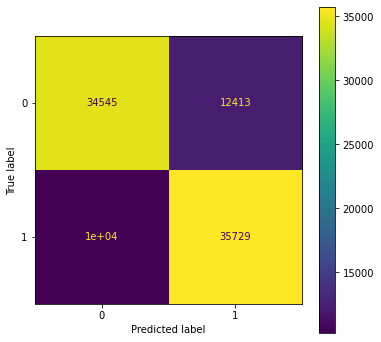

--- ROC AUC ---------------------------------------------------------------------------------------- 



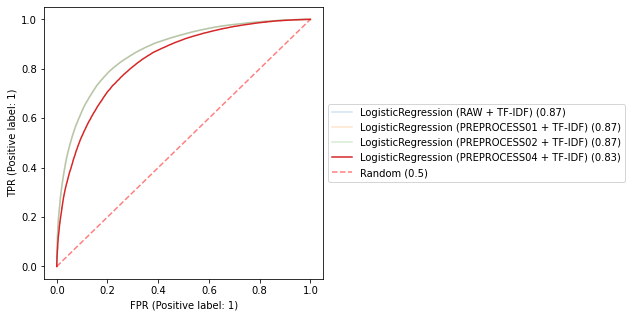

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



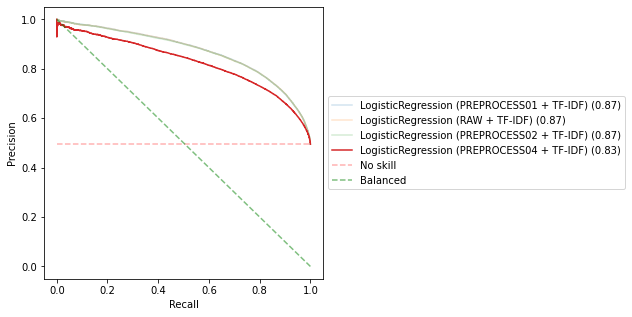

In [34]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

## Testons la même chose avec le jeu de données qui a été filtré avec des règles plus simples

### Séparons le jeu de données en `Train` et `Test` sets

In [35]:
X_train, X_test, y_train, y_test, tfidf_vectorizer_train = preprocess_data(data_preprocess_04_simple, 'lemmas_filtered_simple', test_size=0.2)

DataFrames shapes >> df_train: (371764,), df_test:(92941,), y_train:(371764,), y_test:(92941,)
Preview:
378347                  make tonight
263306    man 10,000 poor girl trust
Name: lemmas_filtered_simple, dtype: object
TF-IDF features: ['00' '000' '000th' ... 'ð¾' 'ð¾ð' 'ð¾ñ']
Sets shapes >> X_train: (371764, 16216), X_test: (92941, 16216)


### Appliquons la Logistic Regression avec ce jeu de données

In [36]:
model_name = "LogisticRegression (PREPROCESS04_simple + TF-IDF)"
max_lr_iter = 3000

grd_log = fit_model(
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref = X_train,
    y_ref = y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7738
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7746
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7746
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7752
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7739

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7744 (std:0.0009)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- LogisticRegression (PREPROCESS04_simple + TF-IDF) ----------------------------------------------

             ROC_AUC : 0.8362
                  F1 : 0.7601
            ACCURACY : 0.7572
           PRECISION : 0.7433
              RECALL : 0.7777
   AVERAGE_PRECISION : 0.8271

       TRAINING-TIME : 113.1407
      INFERENCE-TIME : 0.0207

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.77      0.74      0.75     46958
Prediction = 1       0.74      0.78      0.76     45983

      accuracy                           0.76     92941
     macro avg      

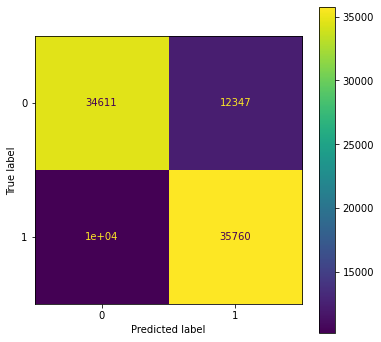

--- ROC AUC ---------------------------------------------------------------------------------------- 



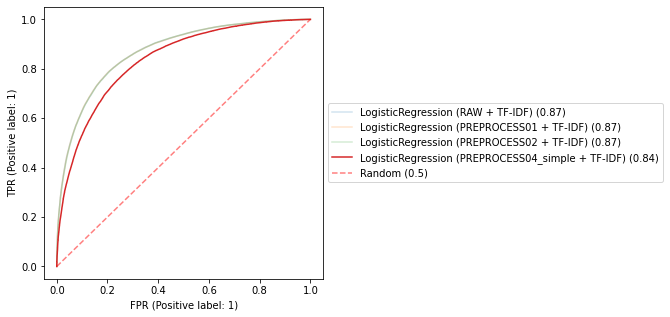

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



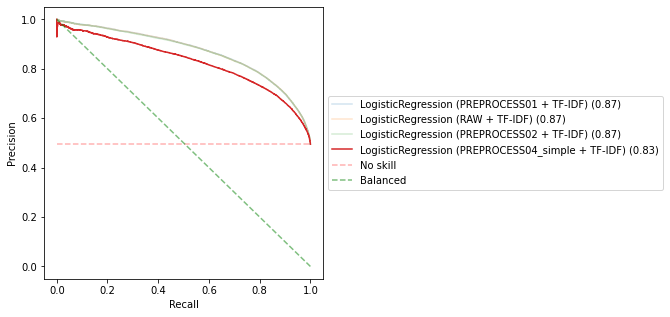

In [37]:
get_scores(model_name, **grd_log, register=True, X_ref=X_test, y_ref=y_test)

---
## 3.6 Comparaison des `scores` <a class="anchor" id="PREPROCESS_scores"></a> [⇪](#menu)

>#### Les scores ci-dessous ont été obtenus avec divers pré-traitements initiaux
> mais la phase final de pré-traitement à dans tous les cas utilisé **TF-IDF** comme moyen de rendre compatible les textes avec le DummyClassifier et la LogisticRegression.

In [38]:
from classification_utils import scores_df

In [39]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier (RAW + TF-IDF),None,"{'random_state': [0], 'strategy': ['stratified']}",0.501250,0.495381,0.496923,0.501286,0.496013,0.497836,22892,23698,23260,23091,1.698857,0.012582
1,LogisticRegression (RAW + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.870318,0.868323,0.790304,0.790857,0.784129,0.796577,36629,36874,10084,9354,207.423611,0.009106
2,LogisticRegression (PREPROCESS01 + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.870305,0.868532,0.790499,0.791029,0.784239,0.796860,36642,36877,10081,9341,209.425086,0.025568
3,LogisticRegression (PREPROCESS02 + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.869891,0.867377,0.790165,0.790555,0.783392,0.797055,36651,36824,10134,9332,211.509896,0.032462
4,LogisticRegression (PREPROCESS03 + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.839572,0.830017,0.764399,0.761634,0.747966,0.781571,35939,34848,12110,10044,111.712448,0.030577
5,LogisticRegression (PREPROCESS03_simple + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.840687,0.831209,0.765390,0.762785,0.749385,0.782093,35963,34931,12027,10020,109.779148,0.015392
6,LogisticRegression (PREPROCESS04 + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.834829,0.825639,0.759182,0.756114,0.742159,0.777005,35729,34545,12413,10254,122.774285,0.015094
7,LogisticRegression (PREPROCESS04_simple + TF-IDF),None,"[{'random_state': [0], 'max_iter': [3000], 'so...",0.836220,0.827120,0.760123,0.757158,0.743343,0.777679,35760,34611,12347,10223,113.140677,0.020658


### Conclusion
> Le meilleur pré-traitement avec la LogisticRegression semble être `LogisticRegression (RAW + TF-IDF)` ou `LogisticRegression (PREPROCESS01 + TF-IDF)`

### Légende
>
> `RAW` 
> - aucun pré-traitement

> `PREPROCESS01`
> - nettoyage avec Twitter-preprocessor

> `PREPROCESS02`
> - nettoyage avec Twitter-preprocessor
> - Tokenization avec SpaCy

> `PREPROCESS03` 
> - nettoyage avec Twitter-preprocessor
> - Tokenization avec SpaCy
> - Filtrage **avancé** des tokens avec SpaCy

> `PREPROCESS03_simple` 
> - nettoyage avec Twitter-preprocessor
> - Tokenization avec SpaCy
> - Filtrage **simple** des tokens avec SpaCy

> `PREPROCESS04` 
> - nettoyage avec Twitter-preprocessor
> - Tokenization avec SpaCy
> - Filtrage **avancé** des tokens avec SpaCy
> - Lemmatization avec SpaCy

> `PREPROCESS04_simple` 
> - nettoyage avec Twitter-preprocessor
> - Tokenization avec SpaCy
> - Filtrage **simple** des tokens avec SpaCy
> - Lemmatization avec SpaCy